(model_averaging)=
# Model Averaging

:::{post} Aug 2022
:tags: model comparison, model averaging
:category: intermediate
:author: Osvaldo Martin
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2


In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

When confronted with more than one model we have several options. One of them is to perform model selection, using for example a given Information Criterion as exemplified by the PyMC examples {ref}`pymc:model_comparison` and the {ref}`GLM-model-selection`. Model selection is appealing for its simplicity, but we are discarding information about the uncertainty in our models. This is somewhat similar to computing the full posterior and then just keeping a point-estimate like the posterior mean; we may become overconfident of what we really know. You can also browse the {doc}`blog/tag/model-comparison` tag to find related posts. 

One alternative is to perform model selection but to consider all the different models together with the computed values of a given Information Criterion. It is important to put all these numbers and tests in the context of our problem so that we and our audience can have a better feeling of the possible limitations and shortcomings of our methods. If you are in the academic world you can use this approach to add elements to the discussion section of a paper, presentation, thesis, and so on.

Yet another approach is to perform model averaging. The idea now is to generate a meta-model (and meta-predictions) using a weighted average of the models. There are several ways to do this. PyMC includes three methods that will be briefly discussed in this notebook. You will find a more thorough explanation in the work by {cite:t}`Yao_2018`. PyMC integrates with ArviZ for model comparison. 


## Pseudo Bayesian model averaging

Bayesian models can be weighted by their marginal likelihood, which is known as Bayesian Model Averaging. While this is theoretically appealing, it is problematic in practice: on the one hand the marginal likelihood is highly sensitive to the specification of the prior, in a way that parameter estimation is not, and on the other, computing the marginal likelihood is usually a challenging task. An alternative route is to use the values of WAIC (Widely Applicable Information Criterion) or LOO (pareto-smoothed importance sampling Leave-One-Out cross-validation), which we will call generically IC, to estimate weights. We can do this by using the following formula:

$$w_i = \frac {e^{ - \frac{1}{2} dIC_i }} {\sum_j^M e^{ - \frac{1}{2} dIC_j }}$$

Where $dIC_i$ is the difference between the i-th information criterion value and the lowest one. Remember that the lower the value of the IC, the better. We can use any information criterion we want to compute a set of weights, but, of course, we cannot mix them. 

This approach is called pseudo Bayesian model averaging, or Akaike-like weighting and is an heuristic way to compute the relative probability of each model (given a fixed set of models) from the information criteria values. Note that the denominator is just a normalization term to ensure that the weights sum up to one.

## Pseudo Bayesian model averaging with Bayesian Bootstrapping

The above formula for computing weights is a nice and simple approach, but with one major caveat: it does not take into account the uncertainty in the computation of the IC. We could compute the standard error of the IC (assuming a Gaussian approximation) and modify the above formula accordingly. Or we can do something more robust, like using a [Bayesian Bootstrapping](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/) to estimate, and incorporate this uncertainty.

## Stacking

The third approach implemented in PyMC is known as _stacking of predictive distributions_ by {cite:t}`Yao_2018`. We want to combine several models in a metamodel in order to minimize the divergence between the meta-model and the _true_ generating model. When using a logarithmic scoring rule this is equivalent to:

$$\max_{w} \frac{1}{n} \sum_{i=1}^{n}log\sum_{k=1}^{K} w_k p(y_i|y_{-i}, M_k)$$

Where $n$ is the number of data points and $K$ the number of models. To enforce a solution we constrain $w$ to be $w_k \ge 0$ and  $\sum_{k=1}^{K} w_k = 1$. 

The quantity $p(y_i|y_{-i}, M_k)$ is the leave-one-out predictive distribution for the $M_k$ model. Computing it requires fitting each model $n$ times, each time leaving out one data point. Fortunately we can approximate the exact leave-one-out predictive distribution using LOO (or even WAIC), and that is what we do in practice.

## Weighted posterior predictive samples

Once we have computed the weights, using any of the above 3 methods,  we can use them to get weighted posterior predictive samples. PyMC offers functions to perform these steps in a simple way, so let's see them in action using an example.

The following example is taken from the superb book {cite:t}`mcelreath2018statistical` by Richard McElreath. You will find more PyMC examples from this book in the repository [Statistical-Rethinking-with-Python-and-PyMC](https://github.com/pymc-devs/pymc-resources/tree/main/Rethinking_2). We are going to explore a simplified version of it. Check the book for the whole example and a more thorough discussion of both the biological motivation for this problem and a theoretical/practical discussion of using Information Criteria to compare, select and average models.

Briefly, our problem is as follows: We want to explore the composition of milk across several primate species. It is hypothesized that females from species of primates with larger brains produce more _nutritious_ milk (loosely speaking this is done _in order to_ support the development of such big brains). This is an important question for evolutionary biologists. To try to give an answer we will use 3 variables:
* two predictor variables - the proportion of neocortex mass compared to the total mass of the brain, and the logarithm of the body mass of the mothers. 
* one predicted variable - the kilocalories per gram of milk. 

With these variables we are going to build 3 different linear models:
 
1. A model using only the neocortex variable
2. A model using only the logarithm of the mass variable
3. A model using both variables

Let start by uploading the data and centering the `neocortex` and `log mass` variables, for better sampling.

In [3]:
d = pd.read_csv(
    "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/milk.csv",
    sep=";",
)
d = d[["kcal.per.g", "neocortex.perc", "mass"]].rename({"neocortex.perc": "neocortex"}, axis=1)
d["log_mass"] = np.log(d["mass"])
d = d[~d.isna().any(axis=1)].drop("mass", axis=1)
d.iloc[:, 1:] = d.iloc[:, 1:] - d.iloc[:, 1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-12.415882,-0.831486
5,0.47,-3.035882,0.158913
6,0.56,-3.035882,0.181513
7,0.89,0.064118,-0.579032
9,0.92,1.274118,-1.884978


Now that we have the data we are going to build our first model using only the `neocortex`.

In [4]:
with pm.Model() as model_0:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + beta * d["neocortex"]

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])
    trace_0 = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    pm.sample_posterior_predictive(trace_0, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [kcal]


The second model is exactly the same as the first one, except we now use the logarithm of the mass

In [5]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + beta * d["log_mass"]

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    trace_1 = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    pm.sample_posterior_predictive(trace_1, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [kcal]


And finally the third model using the `neocortex` and `log_mass` variables

In [6]:
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + pm.math.dot(beta, d[["neocortex", "log_mass"]].T)

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    trace_2 = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    pm.sample_posterior_predictive(trace_2, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [kcal]


Now that we have sampled the posterior for the 3 models, we are going to compare them visually. One option is to use the `forestplot` function that supports plotting more than one trace.

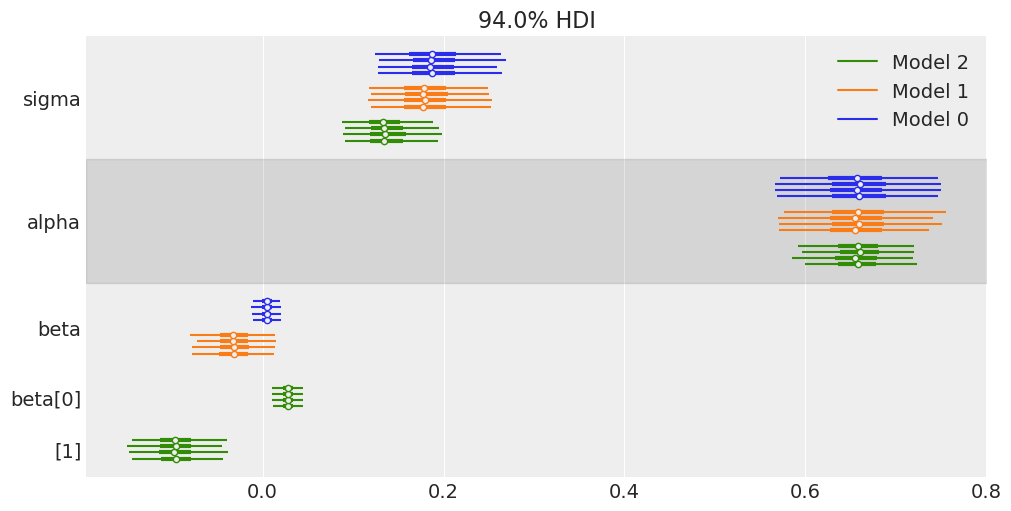

In [7]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

Another option is to plot several traces in a same plot is to use `plot_density`. This plot is somewhat similar to a forestplot, but we get truncated KDE (kernel density estimation) plots (by default 95% credible intervals) grouped by variable names together with a point estimate (by default the mean).

Text(0.5, 1.0, '95% Credible Intervals: sigma')

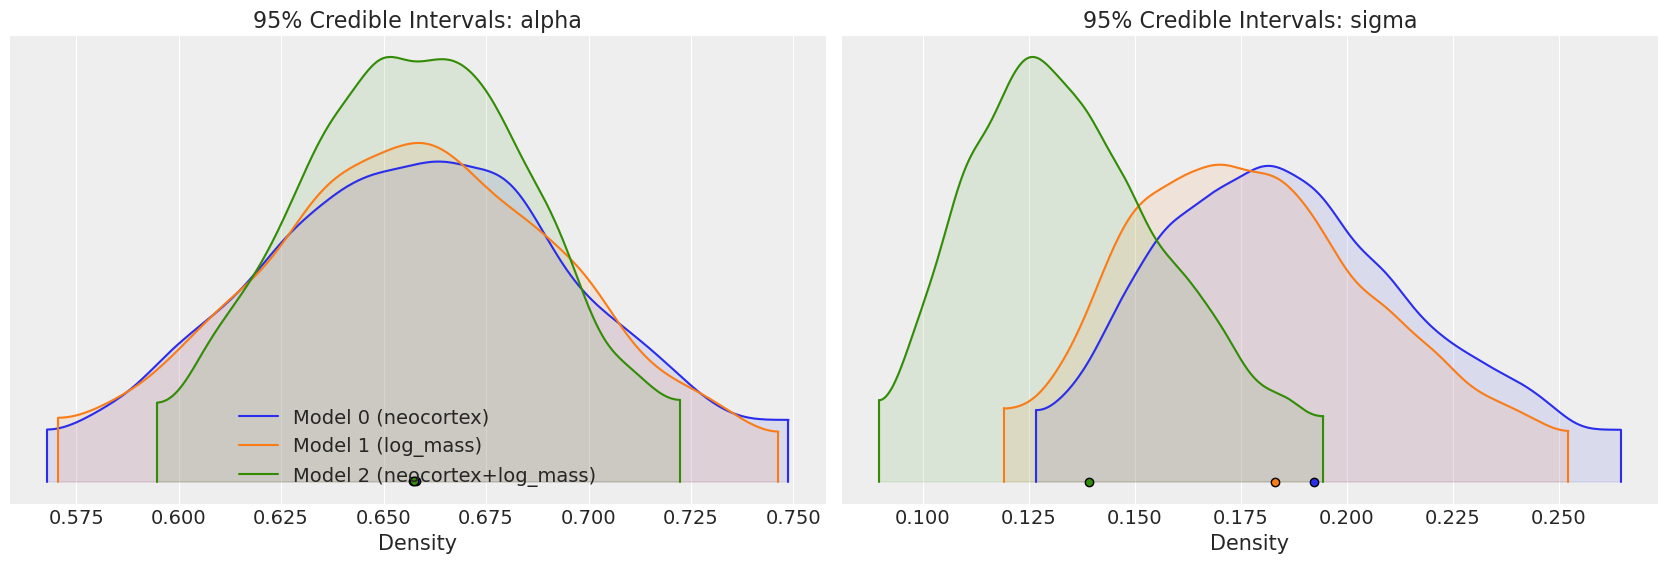

In [8]:
ax = az.plot_density(
    traces,
    var_names=["alpha", "sigma"],
    shade=0.1,
    data_labels=["Model 0 (neocortex)", "Model 1 (log_mass)", "Model 2 (neocortex+log_mass)"],
)

ax[0, 0].set_xlabel("Density")
ax[0, 0].set_ylabel("")
ax[0, 0].set_title("95% Credible Intervals: alpha")

ax[0, 1].set_xlabel("Density")
ax[0, 1].set_ylabel("")
ax[0, 1].set_title("95% Credible Intervals: sigma")

Now that we have sampled the posterior for the 3 models, we are going to use WAIC (Widely applicable information criterion) to compare the 3 models. We can do this using the `compare` function included with ArviZ.

In [9]:
model_dict = dict(zip(["model_0", "model_1", "model_2"], traces))
comp = az.compare(model_dict)
comp

/Users/adrienporter/anaconda3/envs/pymc-docs/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/adrienporter/anaconda3/envs/pymc-docs/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2,0,8.266521,3.253300,0.000000,1.000000e+00,2.557509,0.000000,False,log
model_1,1,4.340585,2.122619,3.925936,0.000000e+00,2.074807,1.723294,False,log
model_0,2,3.551017,1.988888,4.715504,1.221245e-14,1.587097,2.493630,False,log


We can see that the best model is `model_2`, the one with both predictor variables. Note that the DataFrame is ordered from lowest to highest WAIC (_i.e_ from _best_ to _worst_ model). Check the {ref}`pymc:model_comparison` for a more detailed discussion on model comparison.

We can also see that we get a column with the relative `weight` for each model (according to the first equation at the beginning of this notebook). This weights can be _vaguely_ interpreted as the probability that each model will make the correct predictions on future data. Of course this interpretation is conditional on the models used to compute the weights, if we add or remove models the weights will change. It also is dependent on the assumptions behind WAIC (or any other Information Criterion used), so try to not overinterpret these `weights`. 

Now we are going to use computed `weights` to generate predictions based not on a single model, but on the weighted set of models. This is one way to perform model averaging. Using ArviZ we can call the `az.stats.weight_predictions` function as follows:

In [10]:
ppc_w = az.stats.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
).posterior_predictive
ppc_w

<xarray.Dataset>
Dimensions:     (kcal_dim_2: 17, sample: 7999)
Coordinates:
  * kcal_dim_2  (kcal_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * sample      (sample) object MultiIndex
  * chain       (sample) int64 0 2 0 0 0 0 0 1 3 1 2 3 ... 2 1 1 1 0 3 2 1 3 2 3
  * draw        (sample) int64 216 768 211 631 322 ... 1824 1709 95 1165 1267
Data variables:
    kcal        (kcal_dim_2, sample) float64 0.3795 0.3581 ... 0.3967 0.6766
Attributes:
    created_at:                 2023-11-20T05:39:30.790844
    arviz_version:              0.17.0.dev0
    inference_library:          pymc
    inference_library_version:  5.9.2

We are also going to name the PPC for the lowest-WAIC model.

In [11]:
ppc_2 = trace_2.posterior_predictive

A simple way to compare both kind of predictions is to plot their mean and hpd interval.

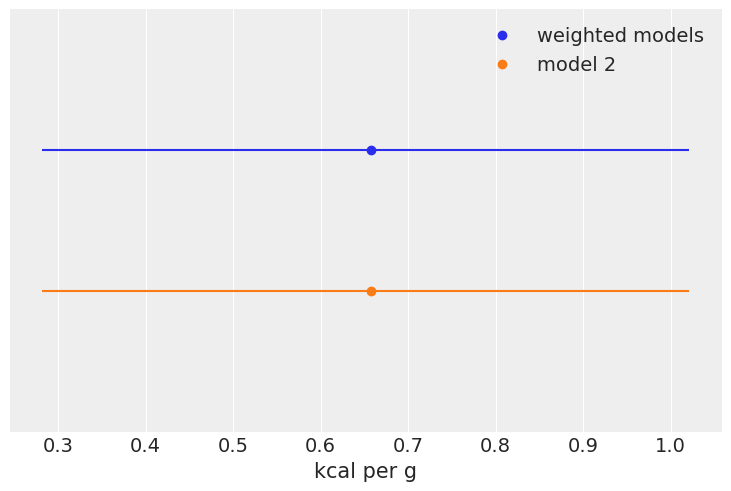

In [12]:
mean_w = ppc_w["kcal"].mean()
hpd_w = az.hdi(ppc_w, var_names="kcal", input_core_dims=[["sample", "kcal_dim_2"]])

mean = ppc_2["kcal"].mean()
hpd = az.hdi(ppc_2, var_names="kcal", input_core_dims=[["chain", "draw", "kcal_dim_2"]])

plt.plot(mean_w, 1, "C0o", label="weighted models")
plt.hlines(1, *hpd_w["kcal"], colors="C0")
plt.plot(mean, 0, "C1o", label="model 2")
plt.hlines(0, *hpd["kcal"], "C1")

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel("kcal per g")
plt.legend();

As we can see the mean value is almost the same for both predictions but the uncertainty in the weighted model is larger. We have effectively propagated the uncertainty about which model we should select to the posterior predictive samples. You can now try with the other two methods for computing weights `stacking` (the default and recommended method) and `pseudo-BMA`.

**Final notes:** 

There are other ways to average models such as, for example, explicitly building a meta-model that includes all the models we have. We then perform parameter inference while jumping between the models. One problem with this approach is that jumping between models could hamper the proper sampling of the posterior.

Besides averaging discrete models, we can sometimes think of continuous versions of them. A toy example is to imagine that we have a coin and we want to estimated its degree of bias, a number between 0 and 1 having a 0.5 equal chance of head and tails (fair coin). We could think of two separate models: one with a prior biased towards heads and one with a prior biased towards towards tails. We could fit both separate models and then average them using, for example, IC-derived weights. An alternative is to build a hierarchical model to estimate the prior distribution. Instead of contemplating two discrete models, we would be computing a continuous model that considers the discrete ones as particular cases. Which approach is better? That depends on our concrete problem. Do we have good reasons to think about two discrete models, or is our problem better represented with a continuous bigger model?

## Authors

* Authored by Osvaldo Martin in June 2017 ([pymc#2273](https://github.com/pymc-devs/pymc/pull/2273))
* Updated by Osvaldo Martin in December 2017 ([pymc#2741](https://github.com/pymc-devs/pymc/pull/2741))
* Updated by Marco Gorelli in November 2020 ([pymc#4271](https://github.com/pymc-devs/pymc/pull/4271))
* Moved from pymc to pymc-examples repo in December 2020 ([pymc-examples#8](https://github.com/pymc-devs/pymc-examples/pull/8))
* Updated by Raul Maldonado in February 2021 ([pymc#25](https://github.com/pymc-devs/pymc-examples/pull/25))
* Updated Markdown and styling by @reshamas in August 2022, ([pymc-examples#414](https://github.com/pymc-devs/pymc-examples/pull/414))
* Updated notebook to use pymc 5 by Adrien Porter in November 2023 

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Nov 19 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

numpy     : 1.25.2
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]
pandas    : 2.1.3
pymc      : 5.9.2
arviz     : 0.17.0.dev0
matplotlib: 3.8.1
json      : 2.0.9

Watermark: 2.4.3



:::{include} ../page_footer.md
:::